In [87]:
# Import packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
import seaborn.objects as so
import bisect
sns.set_theme()

# Problem 1
Use the stock returns in DailyReturn.csv for this problem. DailyReturn.csv contains returns for 100 large US stocks and as well as the ETF, SPY which tracks the S&P500.

Create a routine for calculating an exponentially weighted covariance matrix. If you have a
package that calculates it for you, verify that it calculates the values you expect. This means
you still have to implement it.

Vary lambda ranging from 0 to 1. Use PCA and plot the cumulative variance explained by each eigenvalue for λ ∈ (0, 1)
each chosen.

What does this tell us about values of and the effect it has on the covariance matrix?

In [8]:
# parse the .csv file into dataframe
df=pd.read_csv('DailyReturn.csv',index_col=0)
# transfrom dataframe to array to speed up matrix calculation
data=np.array(df)

##  1. Exponentially Weighted Moving Average

In [9]:
#  Exponentially Weighted Moving Average for Volatility Model -- Exponentially Weighted Covariance
class EWMA:
    """
    Calculate the Exponentially Weighted Covariance & Correaltion Matrix
    
    Parameter: 
        data   -- data for calculating Covariance & Correaltion Matrix
        lambda_  -- smoothing parameter (less than 1)
        flag (optional)  -- a flag to dertermine whether to subtract mean from data.
                            if it set False, data would not subtract its mean.

    fomula: \sigma_t^2=\lambda \sigma_{t-1}^2+(1-\lambda)r_{t-1}^2

    Usage:  
        model=EWMA(data,0.97)
        cov_mat=model.cov_mat
        corr_mat=model.corr_mat
    """
    # initialization 
    def __init__(self,data,lambda_,flag=False):
        self.__data=data if flag==False else data-data.mean(axis=0)
        self.__lambda=lambda_
        self.get_weight() 
        self.cov_matrix()
        self.corr_matrix()

    # calculate the weight matrix
    def get_weight(self):
        n=data.shape[0]
        weight_mat=[(1-self.__lambda)*self.__lambda**(n-i-1) for i in range(n)]
        self.__weight_mat=np.diag(weight_mat)

    # calculate cov_matrix
    def cov_matrix(self):
        self.__cov_mat=self.__data.T @ self.__weight_mat @ self.__data

    # calculate corr_matrix
    def corr_matrix(self):
        n=data.shape[1]
        invSD=np.sqrt(1./np.diag(self.__cov_mat))
        invSD=np.diag(invSD)
        self.__corr_mat=invSD @ self.__cov_mat @ invSD
        return self.__corr_mat

    # plot the cumulative weight
    def plot_weight(self,k=None,ax=None,label=None):
        weight=np.diag(self.__weight_mat)[::-1]
        cum_weight=weight.cumsum()/weight.sum()
        sns.lineplot(cum_weight,ax=ax,label="{:.2f}".format(label) if label!=None else "")
        if ax!=None:
            ax.set_xlabel('Time Lags')
            ax.set_ylabel('Cumulative Weights')
            ax.set_title("Weights of differnent lambda")
        ax.legend(loc='best')

    @property
    def cov_mat(self):
        return self.__cov_mat    

    @property
    def corr_mat(self):
        return self.__corr_mat


## 2. Principal component analysis (PCA)

In [94]:
class PCA:
    """
    Reducing the dimensionality of the dataset.
    
    Parameter:
        cov_mat -- covarinance matrix for dimensionality reduction
        threshold(optional) -- the threshold of cumulative variance explained
    
    Usage:
        PCA_model=PCA(cov_mat,threshold)
        PCA_model.plot()
        PCA_model.pct_explain_val_vec()
    """
    # initialization
    def __init__(self,cov_mat,threshold=None):
        self.__cov_mat=cov_mat
        self.__threshold=threshold
        self.run()
    
    # Conduct the PCA
    def run(self):
        self.__eig_val,self.__eig_vec = np.linalg.eigh(self.__cov_mat)
        # pick the eigenvalues which is bigger than 0 and corresponding eigenvector   
        idx=self.__eig_val>1e-7
        self.__eig_val = self.__eig_val[idx]
        self.__eig_vec = self.__eig_vec [:,idx]       
        # sort since the result given by numpy is lowest to highest, flip them up
        sorted_indices = np.argsort(self.__eig_val)
        self.__eig_val=self.__eig_val[sorted_indices[::-1]]
        self.__eig_vec=self.__eig_vec[:,sorted_indices[::-1]]
        

    # calculate the cumulative percent of variance explained
    def percent_expalined(self,k=None):
        k = self.__eig_val.shape[0] if k==None else k
        k_eig_val=self.__eig_val[:k]

        return k_eig_val.cumsum()/k_eig_val.sum()

    # plot the cumulative percent of variance explained
    def plot(self,k=None,ax=None,label=None):
        explain=self.percent_expalined(k)
        sns.lineplot(explain,ax=ax,label="{:.2f}".format(label) if label!=None else "" )
        if ax!=None:
            ax.set_xlabel('Number of Component')
            ax.set_ylabel('Cumulative Variance Explained')
            ax.set_title("Cumulative Variance Explained via different lambda")
        ax.legend(loc='best')
    
    # Given the threshold, calculate the needed eigenvalues and corresponding eigenvectors
    def pct_explain_val_vec(self):
        eig_val=self.__eig_val
        pct_cum_var=eig_val.cumsum()/eig_val.sum()
        pct_cum_var[-1]=1
        # if cumulative percent of variance explained is larger than threshold, then break
        k = bisect.bisect_left(pct_cum_var, self.__threshold) 
        return self.__eig_val[:k+1],self.__eig_vec[:,:k+1]

## 3. Plot Cumulative Variance Explained & Weights

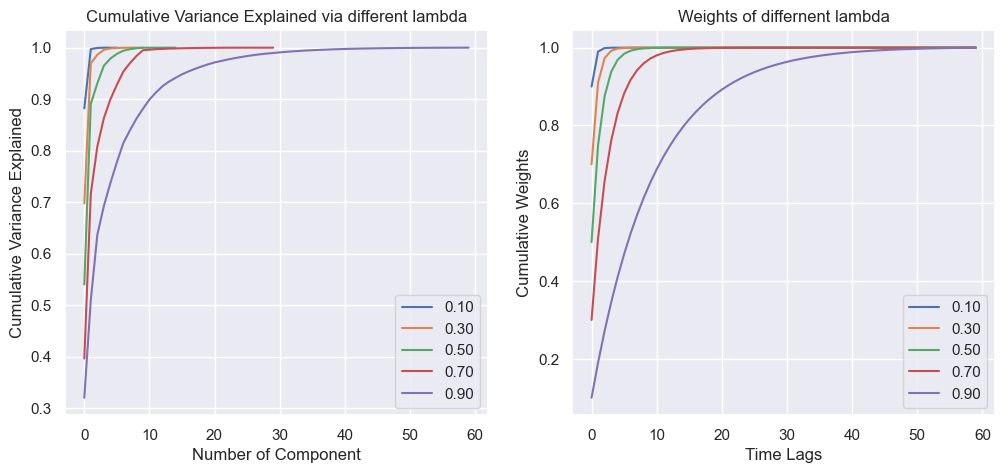

In [80]:
fig, ax = plt.subplots(1,2,figsize=(12, 5))

n=np.arange(0.1,1,0.2)
for i in n:
    model=EWMA(data,i) 
    cov_mat=model.cov_mat 
    PCA_model=PCA(cov_mat) 
    PCA_model.plot(ax=ax[0],label=i) 
    model.plot_weight(ax=ax[1],label=i) 

# Problem 2

Copy the chol_psd(), and near_psd() functions from the course repository – implement in your
programming language of choice. These are core functions you will need throughout the
remainder of the class

Implement Higham’s 2002 nearest psd correlation function.

Generate a non-psd correlation matrix that is 500x500. You can use the code I used in class:
```
    n = 500 
    sigma = fill(0.9, (n, n))
    for i in 1:n
        sigma[i, i] = 1.0  
    end  
    sigma[1, 2] = 0.7357  
    sigma[2, 1] = 0.7357
```
Use near_psd() and Higham’s method to fix the matrix. Confirm the matrix is now PSD.

Compare the results of both using the Frobenius Norm. Compare the run time between the two.
How does the run time of each function compare as N increases?

Based on the above, discuss the pros and cons of each method and when you would use each.
There is no wrong answer here, I want you to think through this and tell me what you think.

## 1. Cholesky Factorization

In [12]:
class NotPsdError(Exception):
    ''' 
    Used for expection raise if the input matrix is not sysmetric positive definite 
    '''
    pass

class chol_psd():
    '''
    Cholesky Decompstion: Sysmetric Positive Definite matrix could use Cholesky 
    algorithm to fatorize the matrix to the product between a lower triangle matrix and
    upper triangle matrix

    Parameter:
        matrix  --  Sysmetric Positive Definite (or Positive Semi-definite) 
                    matrix needed to do Cholesky Factorization.
    
    Formula: 
        matrix=L*L.T

    Usage:
        Chol_model=chol_psd(matrix)
        root=Chol_model.root
    '''
    # initialization
    def __init__(self,matrix):
        self.__psd=matrix
        self.run()

    # Perform the Cholesky Factorization
    def run(self):
        n=self.__psd.shape[0]
        root=np.zeros([n,n])
        for i in range(n):
            # diagonal
            root[i][i] = self.__psd[i][i] - root[i][:i] @ root[i][:i].T
            root[i][i]=0 if 0>=root[i][i]>=-1e-8 else root[i][i]
            # if the diagonal element is less than -1e-8, it might not be PSD
            if root[i][i]<0:
                raise NotPsdError("Not PSD!")
            root[i][i]=np.sqrt(root[i][i])
            
            #below the diagonal
            # if diagonal element is zero, set the following element of that column to be zero too
            if root[i][i]==0:
                continue
            for j in range(i+1,n):
                root[j][i]=(self.__psd[j][i]-root[i,:i] @ root[j,:i])/root[i][i]
        self.__root=root
        self.__ispsd=True

    @property
    def root(self):
        return self.__root   
    
    @property
    def ispsd(self):
        return self.__ispsd 


In [13]:
# Test

# PD
sigma=np.full([5,5],0.9)
np.fill_diagonal(sigma, 1)
root=chol_psd(sigma).root
print(np.allclose(root@root.T,sigma))

# PSD
sigma[0][1]=1
sigma[1][0]=1
v,c=np.linalg.eig(sigma)
root=chol_psd(sigma).root
print(np.allclose(root@root.T,sigma))

# not PSD
# sigma[0][1]=0.7357
# sigma[1][0]=0.7357
# root=chol_psd(sigma).root
# print(np.allclose(root@root.T,sigma))

True
True


## 2. Weighted Frobenius Norm

In [14]:
class Weighted_F_norm:
    '''
    Given the weight matrix, calculate the Weighted Frobenius Norm. (Assume it's diagonal)
    '''
    def compare_F(self,mat_a,mat_b,mat_w):
        '''Give two matrix, use Weighted Frobenius Norm to calculate how close they are'''
        err = mat_a-mat_b #difference
        weighted_err = np.sqrt(mat_w) @ err @ np.sqrt(mat_w) 
        w_F_norm = np.sqrt(np.square(weighted_err).sum())
        return w_F_norm
    
    def calculate_F(self,mat,mat_w):
        "Given one matrix, calculate its Weighted Frobenius Norm"
        weighted_err = np.sqrt(mat_w) @ mat @ np.sqrt(mat_w)
        w_F_norm = np.sqrt(np.square(weighted_err).sum())
        return w_F_norm

## 3. PSD comfirmation

In [15]:
class NotSysmetricError(Exception):
    ''' 
    Used for expection raise if the input matrix is not sysmetric
    '''
    pass

class NegativeEigError(Exception):
    ''' 
    Used for expection raise if matrix has the negative eigvalue
    '''
    pass

class PSD:
    """
    PSD class is used for Positive Semi-Definite Matrix confirmation.
    """
    @staticmethod
    def confirm(psd):
        # make sure sysmetric
        if not np.allclose(psd,psd.T):
            raise NotSysmetricError("Matrix does not equal to Matrix.T")
        # Make sure no negative eigenvalues
        eig_val=np.linalg.eigvals(psd)
        neg_eig=len(eig_val[eig_val<0])
        # No negative eigenvalues or Pass the Cholesky algorithm
        if neg_eig==0 or chol_psd(psd).ispsd:
            print("Matrix is Sysmetric Positive Definite!")
        else:
            raise NegativeEigError("Matrix has negative eigenvalue.")
        

## 4. Generate Non-PSD Correlation Matrix

In [16]:
class Non_psd_mat:
    """
    Used to generate the non-positive semi-definite matrix
    """
    def non_psd_mat(self,n):
        corr = np.full((n, n), 0.9)
        np.fill_diagonal(corr, 1)
        corr[0, 1] = 0.7357  
        corr[1, 0] = 0.7357 
        return corr

## 5. Rebonato and Jackel's Method (PSD Conversion)

In [17]:
class near_psd(Weighted_F_norm):
    '''
    Rebonato and Jackel's Method to get acceptable PSD matrix 
    
    Parameters:
        not_psd -- the matrix which is not positive semi-definite matrix
        weight  -- used for calculating the Weighted Frobenius Norm (Assume it's diagonal)

    Usage:
        near_psd_model=near_psd(non_psd,weight)
        psd=near_psd_model.psd
    '''
    # initialization
    def __init__(self,not_psd,weight):
        self.__not_psd=not_psd
        self.__weight=weight
        self.run() # main function
        self.F_compare_norm(weight) # Weighted Frobenius Norm
        
    def run(self):
        n=self.__not_psd.shape[0]
        # Set the weight matrix to be identity matrix
        invSD = np.eye(n)
        corr=self.__not_psd
        # if the matrix is not correlation matrix, convert it to the correlation matrix
        if not np.allclose(np.diag(self.__not_psd),np.ones(n)):
            invSD=np.diag(1/np.sqrt(np.diag(self.__not_psd)))
            corr=invSD @ self.__not_psd @ invSD
        eig_val,eig_vec=np.linalg.eigh(corr) # eigenvalues & eigenvectors 
        eig_val[eig_val<0]=0 # adjust the negative value to 0
        # get the scale matrix
        scale_mat = np.diag(1/(eig_vec * eig_vec @ eig_val))
        B = np.sqrt(scale_mat) @ eig_vec @ np.sqrt(np.diag(eig_val))
        corr=B @ B.T
        # convert it back into original form
        SD=np.diag(1/np.diag(invSD))
        psd = SD @ corr @ SD
        self.__psd = psd

    # Weighted Frobenius Norm of the difference between near_psd and ono_psd
    def F_compare_norm(self,weight):
        self.__F = self.compare_F(self.__psd,self.__not_psd,weight)

    @property
    def psd(self):
        return self.__psd
    
    @property
    def F(self):
        return self.__F
        

## 6. Higham's Method to find nearest PSD correlation matrix

In [18]:
class Higham_psd(Weighted_F_norm,chol_psd):
    '''
    Higham's Method to get nearest PSD matrix under the measure of Weighted Frobenius Norm
    
    Parameters:
        not_psd -- the matrix which is not positive semi-definite matrix
        weight  -- used for calculating the Weighted Frobenius Norm (Assume it's diagonal)
        epsilon -- the acceptable precision between near_psd and non_psd
        max_iter -- maximum iteration number

    Usage:
        Higham_psd_model=Higham_psd(non_psd,weight)
        psd=Higham_psd_model.psd
    '''
    # initialization
    def __init__(self,not_psd,weight,epsilon=1e-9,max_iter=1e10):
        self.__not_psd=not_psd
        self.__weight=weight
        self.run(epsilon=epsilon,max_iter=max_iter)
        self.F_compare_norm(weight)

    def Projection_U(self,A):
        # Projection to the Space U
        # we assume that the weight matrix is diagonal
        A_copy=A.copy()
        np.fill_diagonal(A_copy,1)
        return A_copy
        
    def Projection_S(self,A):
        # Projection to the Space S
        w_sqrt=np.sqrt(self.__weight)
        eig_val,eig_vec=np.linalg.eigh(w_sqrt @ A @ w_sqrt)
        eig_val[eig_val<0]=0
        A_plus=eig_vec @ np.diag(eig_val) @ eig_vec.T
        w_sqrt_inv=np.diag(1/np.diag(w_sqrt))
        ans = w_sqrt_inv @ A_plus @ w_sqrt_inv
        return ans
    
    def run(self,epsilon,max_iter):
        # iterating process
        Y=self.__not_psd
        F1=np.inf
        F2=self.calculate_F(Y,self.__weight)
        delta=0
        iteration=0
        neg_eig=0
        while abs(F1-F2)>epsilon or neg_eig>0:
            R=Y-delta
            X=self.Projection_S(R)
            delta=X-R
            Y=self.Projection_U(X)
            F1,F2=F2,self.calculate_F(Y,self.__weight)
            iteration+=1
            if iteration>max_iter:
                break
            eig_val=np.linalg.eigvals(Y)
            neg_eig=len(eig_val[eig_val<0])

        self.__F_norm=F2
        self.__psd=Y

    def F_compare_norm(self,weight):
        self.__F = self.compare_F(self.__psd,self.__not_psd,weight)
        
    @property
    def psd(self):
        return self.__psd 
    @property
    def F_norm(self):
        return self.__F_norm 
    
    @property
    def F(self):
        return self.__F

## 7. Efficiency and Precision

In [19]:
class Comparison(PSD,Non_psd_mat):
    '''
    It's used to compare the Rebonato and Jackel's Method, and Higham's Method.
    First, it confirms the results generated by two methods are PSD
    Second, it calculates the run time and precision of each method

    Parameters:
        size -- the size of Non-PSD matrix
    '''
    # initialization
    def __init__(self,size):

        self.__size=size
        self.__weight=np.eye(self.__size)
        self.__mat=self.non_psd_mat(self.__size)
        self.run()
        self.confirm()
    
    # confirms the results generated by two methods are PSD
    def confirm(self):
        mat=self.__mat
        weight=self.__weight
        RJ_psd=self.__RJ_psd.psd
        HG_psd=self.__HG_psd.psd
        print("Rebonato and Jackel's method of {0}*{0} matrix: ".format(self.__size))
        PSD.confirm(RJ_psd)
        print("Higham's method of {0}*{0} matrix: ".format(self.__size))
        PSD.confirm(HG_psd)
    
    # calculates the run time and precision of each method
    def run(self):
        t = time.time()
        self.__RJ_psd=near_psd(self.__mat,self.__weight)
        self.__RJ_run_time = time.time()-t

        t = time.time()
        self.__HG_psd=Higham_psd(self.__mat,self.__weight)
        self.__HG_run_time = time.time()-t

    @property
    def RJ_run_time(self):
        return self.__RJ_run_time

    @property
    def HG_run_time(self):
        return self.__HG_run_time   

    @property
    def HG_psd(self):
        return self.__HG_psd
        
    @property
    def RJ_psd(self):
        return self.__RJ_psd  
    
    @property
    def size(self):
        return self.__size 
        

## 8. Plot the run time & precision

In [75]:
def plot_summary(comparison):
    '''
    Use the Comparison class to calculate the nessary data and plot the result.
    '''
    n=len(comparison)
    method=["Rebonato & Jackel", "Higham"]
    fig, ax = plt.subplots(n,2,figsize=(14,6*n))

    for i in range(n):
        # plot the Run time  
        sns.barplot(x=method,y=[comparison[i].RJ_run_time,comparison[i].HG_run_time],ax=ax[i][0],palette=sns.color_palette("pastel"))
        ax[i][0].set_xlabel('Method')
        ax[i][0].set_ylabel('Run time (seconds)')
        ax[i][0].set_title("Run time of Matrix size={}".format(comparison[i].size),fontweight="bold")
        # plot the Weighted F norm
        sns.barplot(x=method,y=[comparison[i].RJ_psd.F,comparison[i].HG_psd.F],ax=ax[i][1],palette=sns.color_palette("pastel"))
        ax[i][1].set_xlabel('Method')
        ax[i][1].set_ylabel('Weighted F norm')
        ax[i][1].set_title("Weighted F norm of Matrix size={}".format(comparison[i].size),fontweight="bold")

## 10. Confirmation of PSD & Plot

Rebonato and Jackel's method of 10*10 matrix: 
Matrix is Sysmetric Positive Definite!
Higham's method of 10*10 matrix: 
Matrix is Sysmetric Positive Definite!
Rebonato and Jackel's method of 50*50 matrix: 
Matrix is Sysmetric Positive Definite!
Higham's method of 50*50 matrix: 
Matrix is Sysmetric Positive Definite!
Rebonato and Jackel's method of 100*100 matrix: 
Matrix is Sysmetric Positive Definite!
Higham's method of 100*100 matrix: 
Matrix is Sysmetric Positive Definite!
Rebonato and Jackel's method of 200*200 matrix: 
Matrix is Sysmetric Positive Definite!
Higham's method of 200*200 matrix: 
Matrix is Sysmetric Positive Definite!


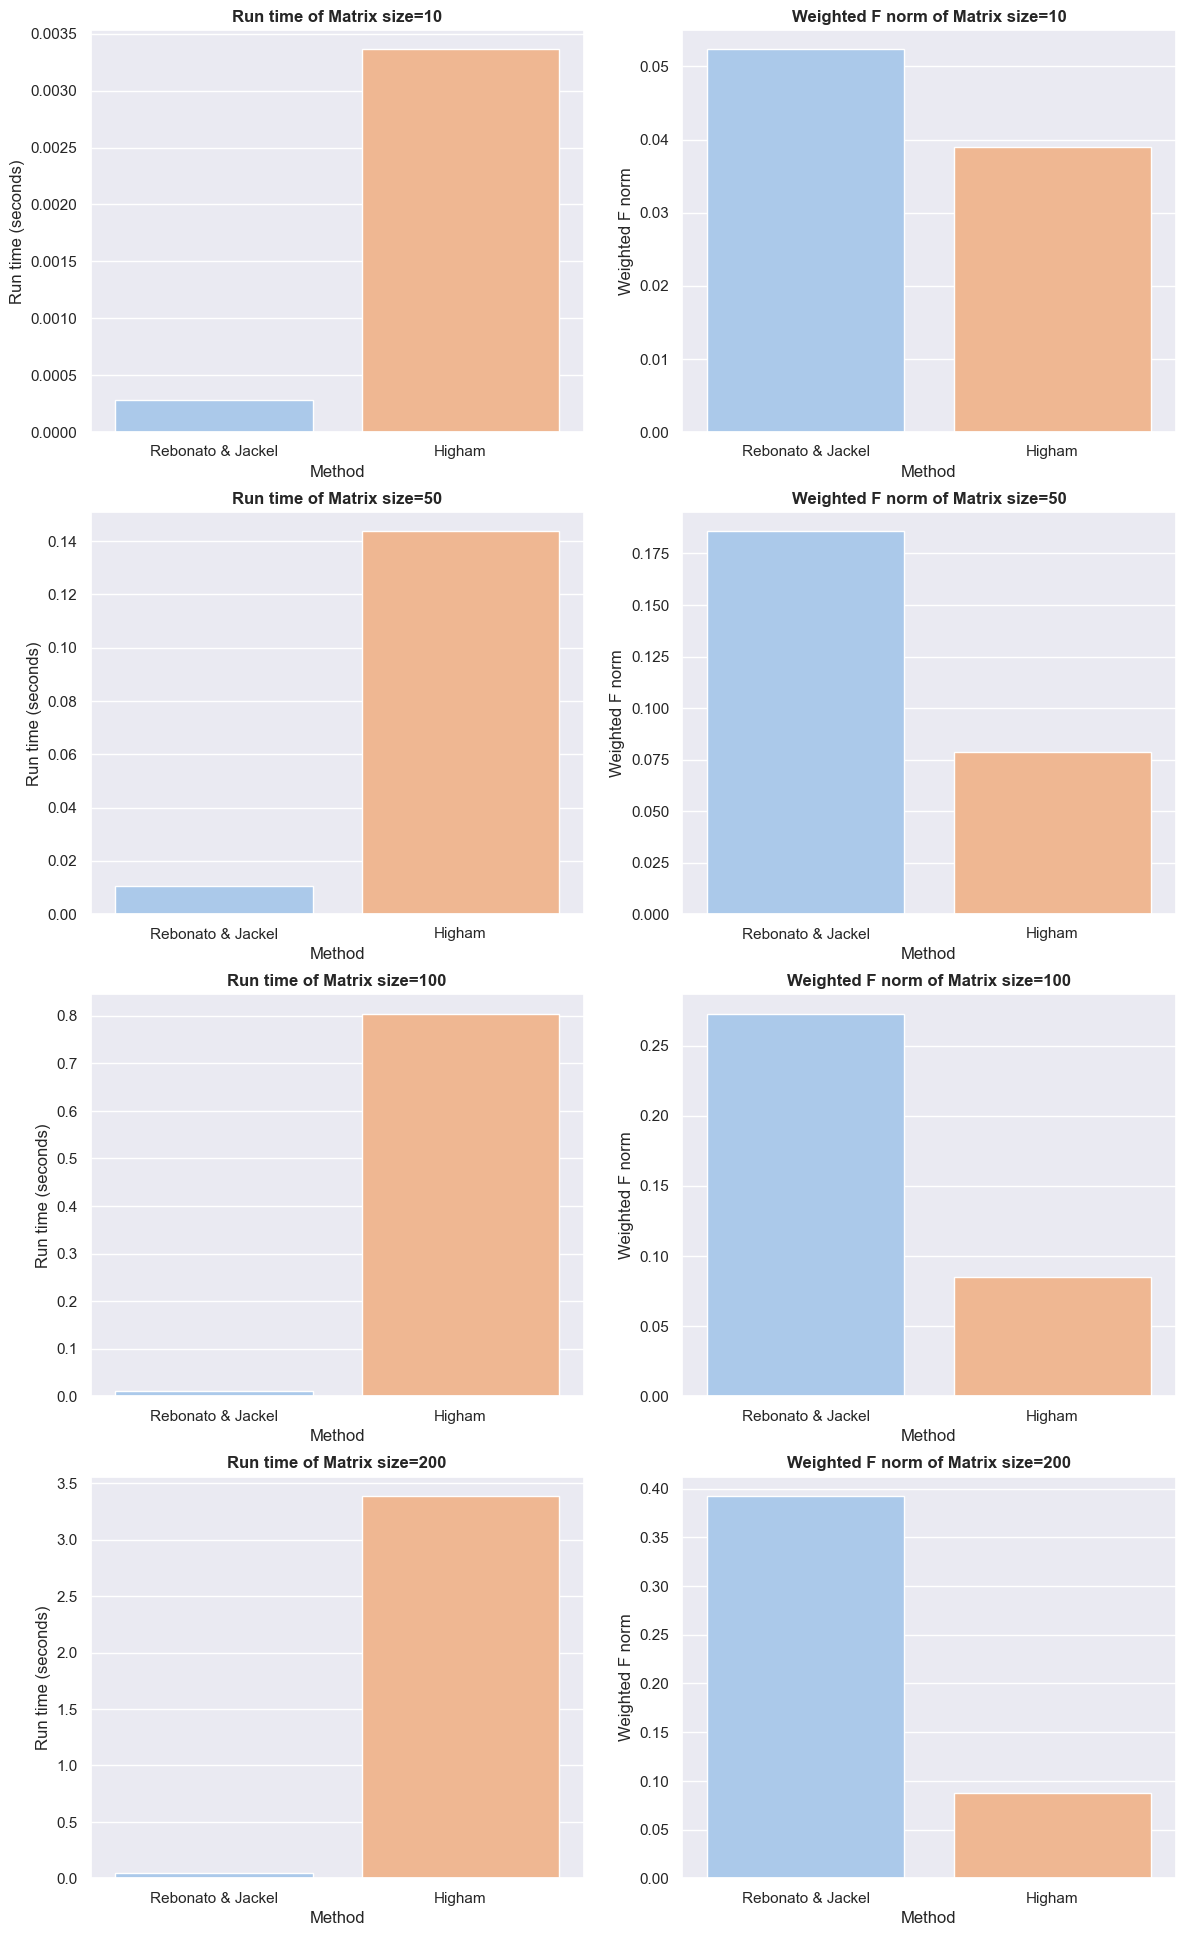

In [81]:
matrix_size=[10,50,100,200]
comparison=[]
for n in matrix_size:
    comparison.append(Comparison(n))
plot_summary(comparison)

# Problem 3

Using DailyReturn.csv.

Implement a multivariate normal simulation that allows for simulation directly from a covariance matrix or using PCA with an optional parameter for % variance explained. If you have a library that can do these, you still need to implement it yourself for this homework and prove that it functions as expected.

Generate a correlation matrix and variance vector 2 ways:

1. Standard Pearson correlation/variance (you do not need to reimplement the cor() and var() functions).
2. Exponentially weighted λ = 0. 97

Combine these to form 4 different covariance matrices. (Pearson correlation + var()), Pearson correlation + EW variance, etc.)

Simulate 25,000 draws from each covariance matrix using:

1. Direct Simulation
2. PCA with 100% explained
3. PCA with 75% explained
4. PCA with 50% explained

Calculate the covariance of the simulated values. Compare the simulated covariance to it’s input matrix using the Frobenius Norm (L2 norm, sum of the square of the difference between the matrices). Compare the run times for each simulation.

What can we say about the trade offs between time to run and accuracy.

## 1. Covariance Generator

In [95]:
class Cov_Generator:
    """
    Convariance Combination of EW covariance, EW correlation, covariance and correlation.

    Parameter:
        data -- data which is used for get the EW covariance, EW correlation, covariance and correlation
    
    Usage:
        cov_generator=Cov_Generator(data)
        cov_generator.EW_cov_cov()
    """
    def __init__(self,data):
        self.__data = data
        self.__EWMA = EWMA(data,0.97)
        self.__EW_cov = self.__EWMA.cov_mat
        self.__EW_corr = self.__EWMA.corr_mat
        self.__cov = np.cov(data.T)
        invSD=np.diag(1/np.sqrt(np.diag(self.__cov)))
        self.__corr = invSD @ self.__cov @ invSD
    
    # EW_cov + cov
    def EW_cov_cov(self):
        return self.__EW_cov+self.__cov
    # EW_corr + corr
    def EW_corr_corr(self):
        return self.__EW_corr+self.__corr
    # EW_cov + corr
    def EW_cov_corr(self):
        return self.__EW_cov+self.__corr
    # EW_corr + cov
    def EW_corr_cov(self):
        return self.__EW_corr+self.__cov
    # EW_corr + EW_cov
    def EW_corr_EW_cov(self):
        return self.__EW_corr+self.__EW_cov
    # corr + cov
    def corr_cov(self):
        return self.__corr+self.__cov


## 2. Simulator for all methods

In [96]:
class Simulator(Weighted_F_norm):
    """
    Simulator for DirectSimulation & PCA_Simulation

    Parameter: 
        cov_mat -- covariance matrix
        draw_num -- the number of sample draw from simulation
    """

    def __init__(self,cov_mat,draw_num):
        self.__cov_mat=cov_mat
        self.__draw_num=draw_num
        self.__Direct_run_time=None
        self.__PCA_run_time=None
        self.__X=None

    def DirectSimulation(self):
        """Cholesky"""
        t = time.time()
        root=chol_psd(self.__cov_mat).root
        n=root.shape[0]
        rand_norm=np.random.normal(0, 1, size=(n, self.__draw_num))
        X= root @ rand_norm
        self.__Direct_run_time = time.time()-t
        self.__X=X
        return X

    def PCA_Simulation(self,threshold):
        """PCA"""
        t = time.time()
        PCA_model=PCA(self.__cov_mat,threshold=threshold)
        eig_val,eig_vec=PCA_model.pct_explain_val_vec()
        B= eig_vec @ np.diag(np.sqrt(eig_val))
        n=B.shape[1]
        rand_norm=np.random.normal(0, 1, size=(n, self.__draw_num))
        X= B @ rand_norm
        self.__PCA_run_time = time.time()-t
        self.__X=X
        return X

    # get the F norm of difference between covariance of simulation and original covariance
    def err_F_norm(self):
        n=self.__cov_mat.shape[0]
        w=np.eye(n)
        return self.compare_F(self.__cov_mat,np.cov(self.__X),w)
     
    @property
    def Direct_run_time(self):
        return self.__Direct_run_time

    @property
    def PCA_run_time(self):
        return self.__PCA_run_time
    

## 3. Simulation!

Run Time Data: [[0.06535887718200684, 0.06027698516845703, 0.02425980567932129, 0.012452125549316406], [0.08846378326416016, 0.07654905319213867, 0.03210878372192383, 0.013366937637329102], [0.089691162109375, 0.08662796020507812, 0.019320011138916016, 0.01631784439086914], [0.07056093215942383, 0.1106717586517334, 0.02961587905883789, 0.022992849349975586], [0.07644391059875488, 0.061120033264160156, 0.019450902938842773, 0.0062673091888427734], [0.08181381225585938, 0.09588193893432617, 0.019677400588989258, 0.008585929870605469]]
F Norm: [[0.0005821184141059646, 0.00041909433977525693, 0.0030516067288435655, 0.006646681620616205], [1.2787328006821506, 1.1411625253396553, 9.546975669273655, 17.91890021931697], [0.6988667899820644, 0.5659627687686913, 4.720928214895554, 9.193552047995757], [0.6828956890986679, 0.6677325169918691, 4.565956457468214, 10.713676908655986], [0.6407483075677565, 0.8073738601025285, 4.553413311842998, 10.716199480377195], [0.6606518283938154, 0.6371403226963

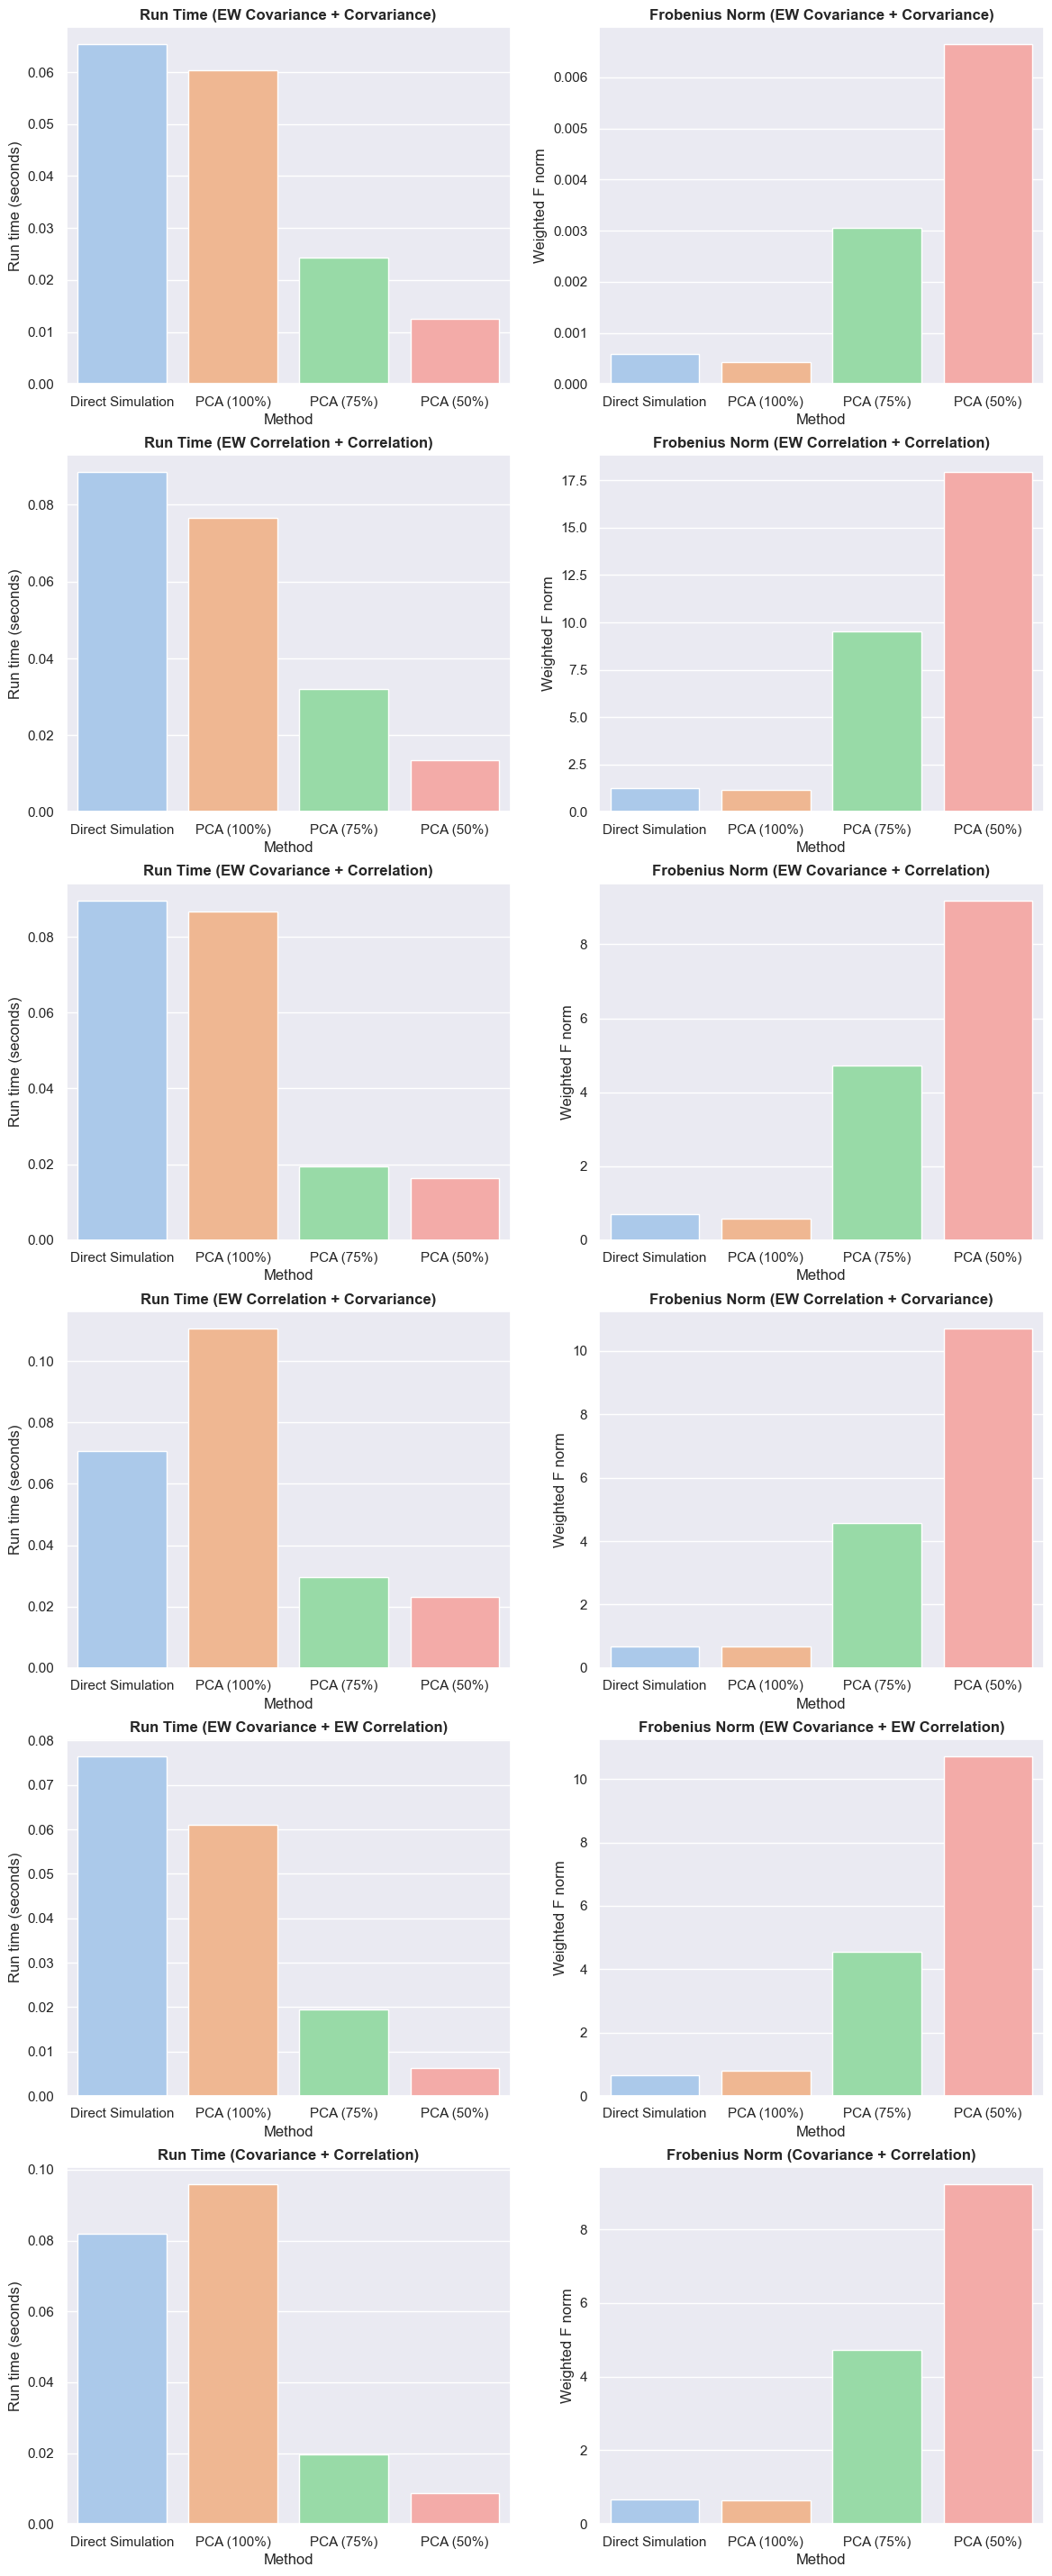

In [128]:
# Get a list of all the combinations of covariance and correlation
cov_gen = Cov_Generator(data)
cov_list=[]
cov_list.append(cov_gen.EW_cov_cov())
cov_list.append( cov_gen.EW_corr_corr())
cov_list.append( cov_gen.EW_cov_corr())
cov_list.append( cov_gen.EW_corr_cov())
cov_list.append( cov_gen.EW_corr_EW_cov())
cov_list.append( cov_gen.corr_cov())
cov_name=["EW Covariance + Corvariance","EW Correlation + Correlation","EW Covariance + Correlation","EW Correlation + Corvariance","EW Covariance + EW Correlation","Covariance + Correlation"]


draw_num=25000

plt_n=len(cov_list)
fig, ax = plt.subplots(plt_n,2,figsize=(14,6*plt_n))
all_run_time=[]
all_F_norm=[]
# plot
for i in range(plt_n):
    cov_mat=cov_list[i]
    simulator = Simulator(cov_mat,draw_num)
    Methods=["Direct Simulation","PCA (100%)","PCA (75%)", "PCA (50%)"]
    run_time=[]
    Err_F_norm=[]

    # Direct Simulation
    simulator.DirectSimulation()
    run_time.append(simulator.Direct_run_time)
    Err_F_norm.append(simulator.err_F_norm())

    percent_explained=[1,0.75,0.5]
    # PCA Simulation
    for pct in percent_explained:
        simulator.PCA_Simulation(pct)
        run_time.append(simulator.PCA_run_time)
        Err_F_norm.append(simulator.err_F_norm())

    # collect data
    all_run_time.append(run_time)
    all_F_norm.append(Err_F_norm)

    # plot the Run time 
    sns.barplot(x=Methods,y=run_time,ax=ax[i][0],palette=sns.color_palette("pastel"))
    ax[i][0].set_xlabel('Method')
    ax[i][0].set_ylabel('Run time (seconds)')
    ax[i][0].set_title("Run Time ({})".format(cov_name[i]),fontweight="bold")
    
    # plot the F norm
    sns.barplot(x=Methods,y=Err_F_norm,ax=ax[i][1],palette=sns.color_palette("pastel"))
    ax[i][1].set_xlabel('Method')
    ax[i][1].set_ylabel('Weighted F norm')
    ax[i][1].set_title("Frobenius Norm ({})".format(cov_name[i]),fontweight="bold")
    
print("Run Time Data:",all_run_time)
print("F Norm:",all_F_norm)

